Import statements

In [212]:
import cv2 , os , random
import numpy as np 
from matplotlib import pyplot as plt

Utility functions

In [213]:
def showImage(img , shape , label , cmap = 'gray'):
    plt.subplot(3,6,1)
    plt.title(label)
    plt.imshow(img.reshape(shape), cmap=cmap)
    plt.subplots_adjust(right=1.2, top=1.2)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    plt.show()

Loading all the faces

# LFW DATASET

In [214]:
"""*CHANGED(NEW)"""
import tarfile
from os import listdir
from os.path import join, isdir, exists
import cv2

import numpy as np


if not os.path.exists("./datasets/LFW_funneled/lfw_funneled"):
    # extract the dataset if it doesnt exist. 
    # takes a while to extract. so will only happen first time its run to save time.
    if not os.path.exists("./lfw-funneled.tgz"):
        raise (
            "Dataset nowhere to be found. Ensure 'lfw-funneled.tgz is in this directory'")
    tf = tarfile.open('./lfw-funneled.tgz')
    tf.extractall('./datasets/LFW_funneled/')


def _fetch_lfw(data_folder_path, color=False, resize=None,
               min_faces_per_person=20):
    """
    Perform the actual data loading for the lfw people dataset
    """
    # min_faces_per_person = max(20, min_faces_per_person)

    person_names, file_paths = [], []
    image_shape = None
    for person_name in sorted(listdir(data_folder_path)):
        folder_path = join(data_folder_path, person_name)
        if not isdir(folder_path):
            continue
        paths = [join(folder_path, f) for f in listdir(folder_path)]
        n_pictures = len(paths)
        if n_pictures >= min_faces_per_person:
            person_name = person_name.replace('_', ' ')
            person_names.extend([person_name] * n_pictures)
            file_paths.extend(paths)

    n_faces = len(file_paths)

    target_names = np.unique(person_names)
    target = np.searchsorted(target_names, person_names)
    faces = []

    for face in file_paths:
        grayScale = cv2.imread(face, cv2.IMREAD_GRAYSCALE)
        # image = cv2.imread(face)
        # grayScale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        grayScale = grayScale[50:200].transpose()[75:175].transpose()
        image_shape = grayScale.shape

        faces.append(grayScale.flatten())

    faces = np.array([*faces])

    # # shuffle the faces with a deterministic RNG scheme to avoid having
    # # all faces of the same person in a row

    indices = np.arange(n_faces)
    np.random.RandomState(42).shuffle(indices)
    faces, target = faces[indices], target[indices]
    return faces, target, target_names, image_shape


def fetch_lfw(data_home='.\datasets\LFW_funneled\lfw_funneled/', min_faces_per_person=50):
    """
    Extracts the faces from the LFW-funneled dataset. Will only include people
    who have enough images to satisfy the min_faces_per_person constraint.

    *Applies grayscale during extraction.

    Returns: Dict object with keys:
        {
            data: faces
            target: labels(number encoded)
            target_names: labels(names of the people)
        }
    """
    faces, target, target_names, image_shape = _fetch_lfw(
        data_folder_path=data_home, min_faces_per_person=min_faces_per_person)
    return {'data': faces.reshape(len(faces), -1), 'images': faces, 'target': target, 'target_names': target_names, 'image_shape': image_shape}

In [215]:
"""*CHANGED(NEW)"""

min_faces_per_person = 120 # Change this to see how it affects it if u want. so far accuracy goes down with the number

lfw = fetch_lfw(min_faces_per_person=min_faces_per_person)

X = lfw['data']
y = lfw['target']
target_names = lfw['target_names']
image_shape = lfw['image_shape']

In [216]:
"""*CHANGED(NEW)"""

from sklearn.model_selection import train_test_split        
# We can do our own function to do this, ......but this has a randomizer for both train and test sets and im too lazy

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)

#########################
faces = X_train
testFaces = X_test

facesName = y_train
testFacesName = y_test

imageShape = image_shape
#########################

Finding the mean face and zero centering the faces accordingly

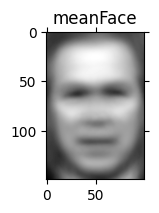

In [217]:
meanFace = faces.mean(axis = 0)
showImage(img=meanFace , shape=imageShape , label='meanFace')

# zero centering the faces
faces = faces - meanFace 

Calculating the covariance of the face collections and it's eigen decomposition to obtain the eigenvectors and eigenvalues.

In [218]:
"""*CHANGED eigenDecomposition references (og is commented)"""
covariance = np.cov(faces)

# eigenDecomposition = np.linalg.eig(covariance) 
eigenValues, eigenVectors = np.linalg.eig(covariance) 

# transposed them beacuse the colunm correspond to a single eigen vector , so I want them to be reflected in a row
# eigenVectors = eigenDecomposition.eigenvectors
# eigenValues = eigenDecomposition.eigenvalues

print(eigenVectors.shape)

unsortedEigenValues = eigenValues.tolist()
sortedEigenValues = eigenValues.tolist()
sortedEigenValues.sort(reverse = True)

(773, 773)


Now lets choose K eigenvectors that will keep most of our variance (99% of it to be exact) and we will drop the rest. (Using this accuracy consistently above 50%)

After experimenting with the above idea of keeping eigenvectors that preserve 99% of the variance , I have noticed that most of the eigenvectors that are included describe the  background of the pictures , since the pictures I have used aren't properly croped. So for this specific case I will be using the first 10 eigenvectors to generate eigenfaces because they are the onces that are more descriptive of facial features and not the backround features. ( Using this accuracy is mostly in mid 40s max is 50%)

In [219]:
# total sum of the eigenvalues
sum = eigenValues.sum(0)

# sum of the eigenvalues upto a given index
priorSum = 0


# selected eigenVectors
selectedEigen = []


for eigenValue in sortedEigenValues:
    priorSum += eigenValue
    capturedVariance = (priorSum / sum)
    if capturedVariance >= 0.99:
        index = unsortedEigenValues.index(eigenValue)
        selectedEigen.append(eigenVectors[ : , index])
        break
    
    index = unsortedEigenValues.index(eigenValue)
    selectedEigen.append(eigenVectors[ : , index])

print("Kept eigenvectors: " , len(selectedEigen) / len(sortedEigenValues))

eigenVectors = np.array(selectedEigen)       
print(eigenVectors.shape)


Kept eigenvectors:  0.6235446313065977
(482, 773)


Now we take the eigenvectors and use them to transform our original images of faces into eigenspaces

In [220]:
eigenSpace = eigenVectors.dot(faces)
print(eigenSpace.shape)
print(faces.shape)

# print(eigenSpace.dot(faces.transpose()).shape)
for eigenFace in eigenSpace:
    pass
    # showImage(img=eigenFace , shape=imageShape , label='Eigenface')

(482, 15000)
(773, 15000)


Now lets project every face onto the face space , in other words calculate its weight in that space

In [221]:
projection = faces.dot(eigenSpace.transpose())
print(projection.shape)

(773, 482)


Now lets calculate our threshold

In [222]:
# loop through all of the projections and calculate the eucledian distance between them
max = 0
for point in projection:
    difference = projection - point
    distance = difference * difference
    distance = distance.sum(axis=1)
    
    if max < distance.max():
        max = distance.max()

# then choose the max and divide it by two
threshold = max * 0.5
print(threshold)

2.3003840261153984e+17


Now let us test our algorithm on previously unseen images.

1) First let us subtract the mean face from the test faces

In [223]:
testFaces = testFaces - meanFace

2. Project every face onto the eigen space

In [224]:
testProjections = testFaces.dot(eigenSpace.transpose())
print(testProjections.shape)

(258, 482)


3. Calculate the Eucledean distance between a projected test face and each projected training faces 

In [225]:
testIndex = 0
correct = 0
for testFace in testProjections:
    # calculate the distance the projection has from the training projection
    difference = projection - testFace
    eucleadeanDistance = (difference * difference).sum(axis = 1)
    shortestDistance = eucleadeanDistance.min()
    
    # the corresponding image with the shortest distance
    index = eucleadeanDistance.tolist().index(shortestDistance)
    predictedName = facesName[index]
    actualName = testFacesName[testIndex]

    # here I will check if the mix distance is greater than the threshold and so on
    # but for the time being since there aren't any new faces and non-face objects lets skip that ok bro
    if predictedName == actualName:
        correct += 1
    
    testIndex += 1

print(f'Accuracy : {correct / (testIndex + 1)}')
    

Accuracy : 0.5675675675675675


['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Tony Blair']


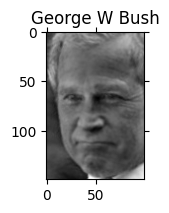

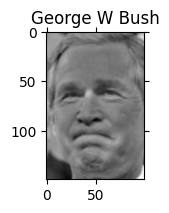

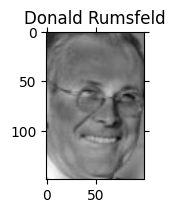

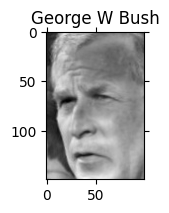

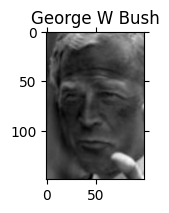

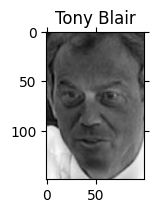

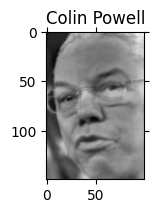

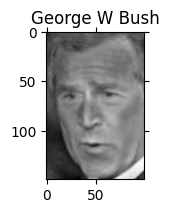

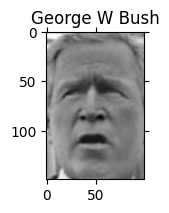

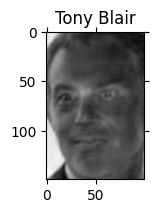

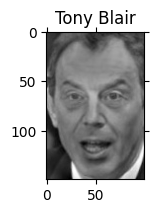

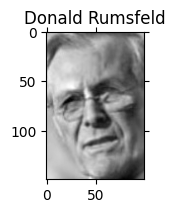

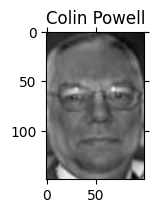

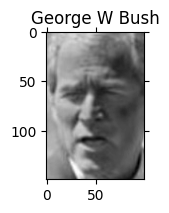

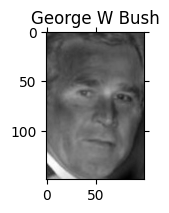

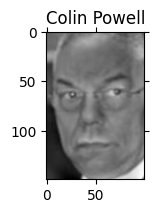

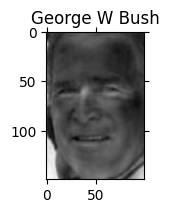

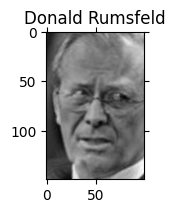

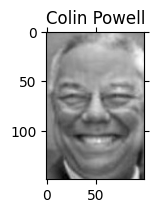

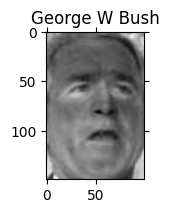

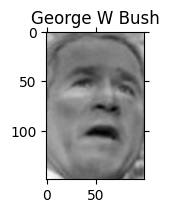

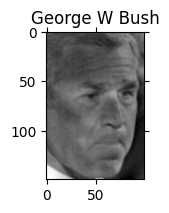

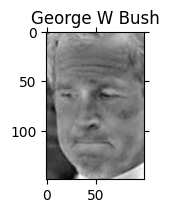

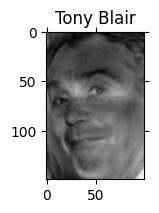

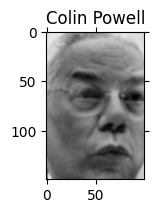

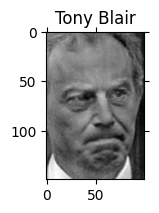

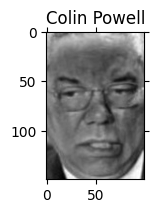

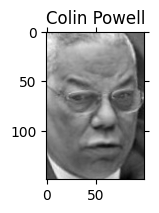

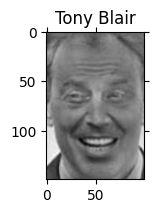

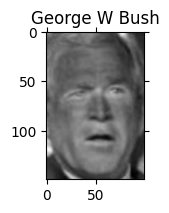

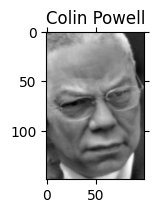

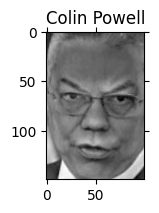

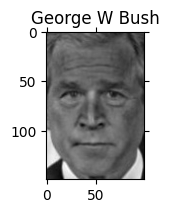

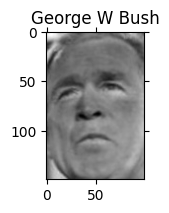

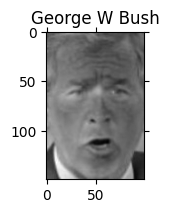

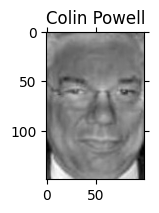

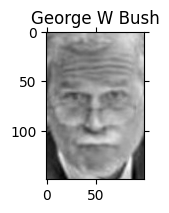

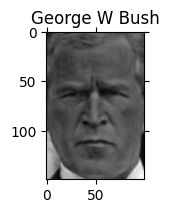

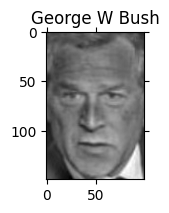

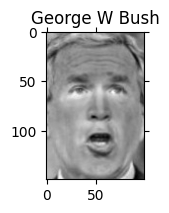

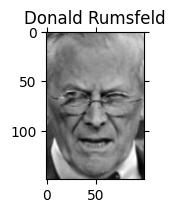

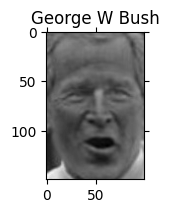

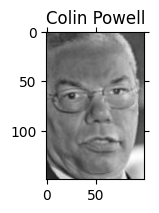

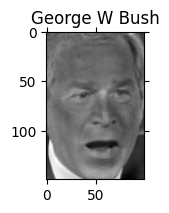

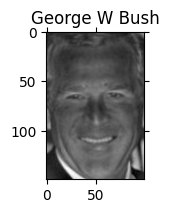

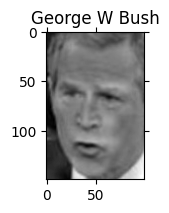

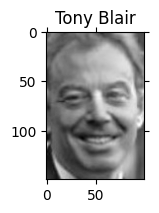

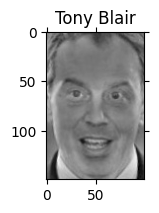

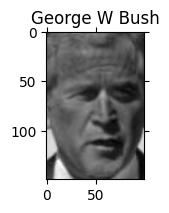

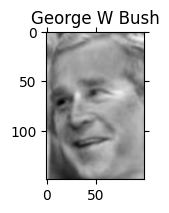

In [226]:
"""*CHANGED"""

print(target_names)     # people in the training/test sets

for i, face in enumerate(faces):
    if i==50:
        break
    showImage(face, imageShape, target_names[facesName[i]])